# Pretrained DALL-E model fine tuning

In [6]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset
from PIL import Image
from dall_e import map_pixels, unmap_pixels, load_model
import os
from tqdm import tqdm
import matplotlib.pyplot as plt


In [ ]:

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
enc = load_model("https://cdn.openai.com/dall-e/encoder.pkl", device)
dec = load_model("https://cdn.openai.com/dall-e/decoder.pkl", device)


In [7]:

def reset_weights(m):
    if isinstance(m, (nn.Conv2d, nn.ConvTranspose2d)):
        nn.init.xavier_uniform_(m.weight)  
        if m.bias is not None:
            nn.init.zeros_(m.bias)

class FootballPlayerDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.image_paths = [os.path.join(root_dir, fname) for fname in os.listdir(root_dir) if fname.endswith(('.png', '.jpg', '.jpeg'))]

    def __len__(self):
        return len(self.image_paths)
    
    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        image = Image.open(img_path).convert('RGB')
        if self.transform:
            image = self.transform(image)
        return image, 0 

dataset_dir = "./data/images"
transform = transforms.Compose([
    transforms.Resize((144, 144)),
    transforms.ToTensor()
])
dataset = FootballPlayerDataset(root_dir=dataset_dir, transform=transform)
dataloader = DataLoader(dataset, batch_size=16, shuffle=True)

def fine_tune_model(enc, dec, dataloader, epochs=10, lr=1e-5):
    enc.eval()  
    dec.train()  
    optimizer = optim.Adam(dec.parameters(), lr=lr)
    
    for epoch in range(epochs):
        total_loss = 0
        for images, _ in tqdm(dataloader):
            images = images.to(device)
            images = map_pixels(images)  
            
            with torch.no_grad():  
                z_logits = enc(images)
                z_indices = torch.argmax(z_logits, dim=1)  
                z_one_hot = nn.functional.one_hot(z_indices, num_classes=enc.vocab_size).permute(0, 3, 1, 2).float()
            
            x_stats = dec(z_one_hot).float()
            reconstructed_images = (torch.tanh(x_stats[:, :3]) + 1) / 2  # Rescale to [0, 1]

            reconstructed_images = reconstructed_images.clamp(0, 1)

            loss = nn.functional.mse_loss(reconstructed_images, images)
            optimizer.zero_grad()
            loss.backward()
            torch.nn.utils.clip_grad_norm_(dec.parameters(), max_norm=1.0)  
            optimizer.step()
            
            total_loss += loss.item()
        
        print(f"Epoch [{epoch + 1}/{epochs}], Loss: {total_loss / len(dataloader):.4f}")
        visualize_reconstruction(images, reconstructed_images)

def visualize_reconstruction(original_images, reconstructed_images):
    fig, axes = plt.subplots(2, 5, figsize=(12, 6))
    for i in range(5):
        axes[0, i].imshow(original_images[i].permute(1, 2, 0).cpu().numpy())
        axes[0, i].set_title("Original")
        axes[0, i].axis('off')

        reconstructed_img = reconstructed_images[i].detach().permute(1, 2, 0).cpu().numpy()
        axes[1, i].imshow(reconstructed_img)
        axes[1, i].set_title("Reconstructed")
        axes[1, i].axis('off')
    plt.show()


In [ ]:
for name, param in dec.named_parameters():
    print(f"{name}: requires_grad = {param.requires_grad}")


  1%|          | 9/921 [00:01<02:40,  5.68it/s]/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/PIL/Image.py:1054: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
100%|██████████| 921/921 [02:40<00:00,  5.72it/s]


Epoch [1/10], Loss: 0.0103


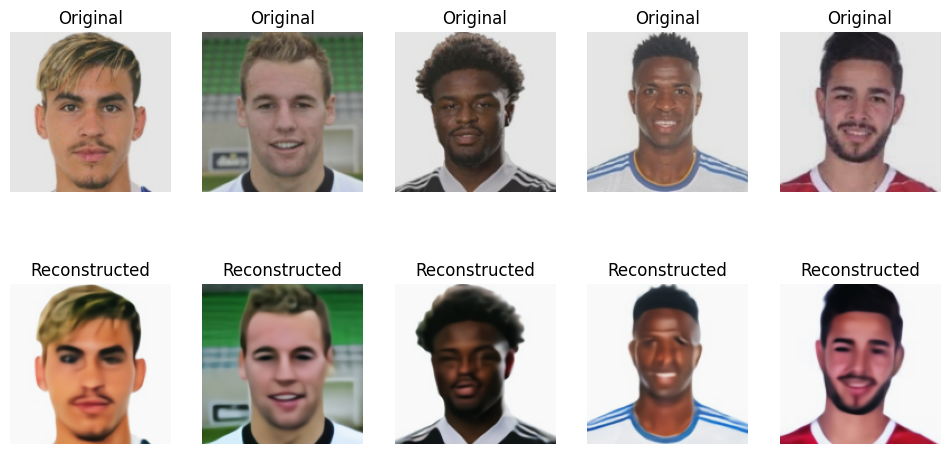

100%|██████████| 921/921 [02:41<00:00,  5.71it/s]


Epoch [2/10], Loss: 0.0063


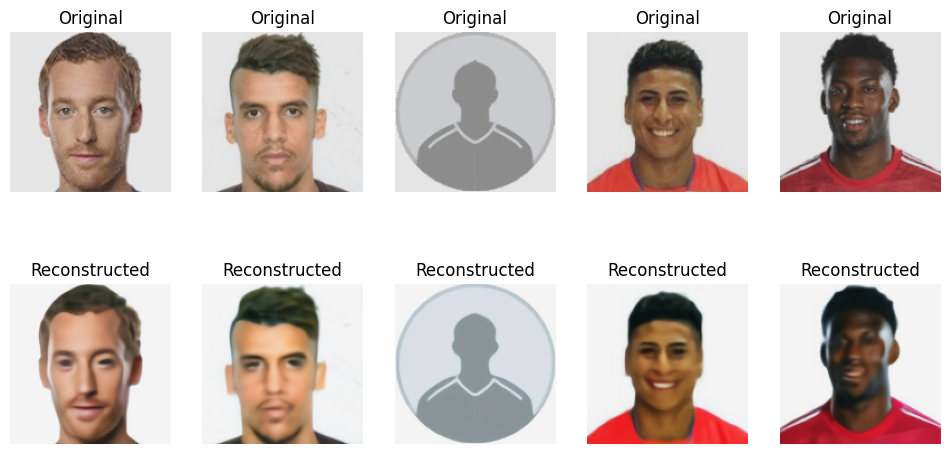

100%|██████████| 921/921 [02:41<00:00,  5.69it/s]


Epoch [3/10], Loss: 0.0034


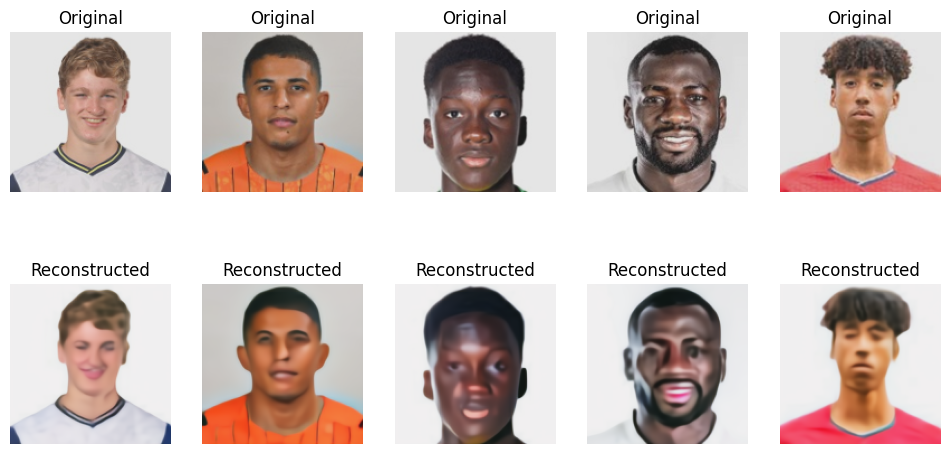

100%|██████████| 921/921 [02:41<00:00,  5.71it/s]


Epoch [4/10], Loss: 0.0021


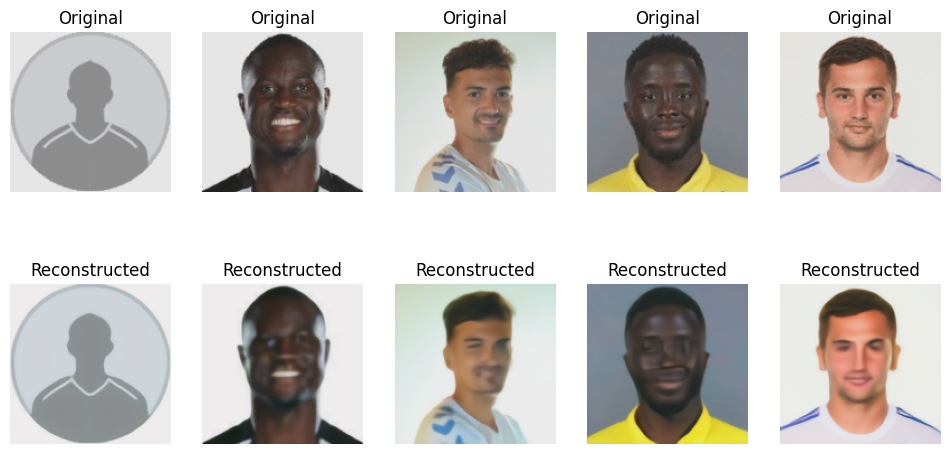

100%|██████████| 921/921 [02:41<00:00,  5.70it/s]


Epoch [5/10], Loss: 0.0014


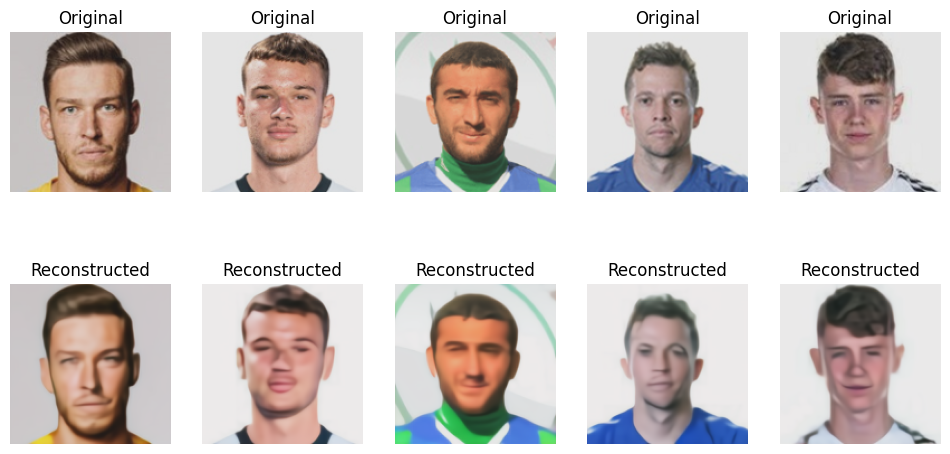

100%|██████████| 921/921 [02:42<00:00,  5.68it/s]


Epoch [6/10], Loss: 0.0011


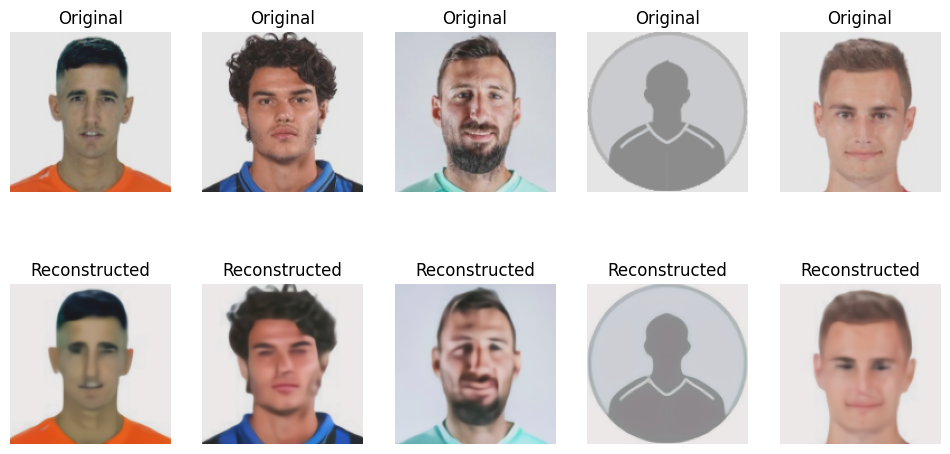

100%|██████████| 921/921 [02:41<00:00,  5.69it/s]


Epoch [7/10], Loss: 0.0009


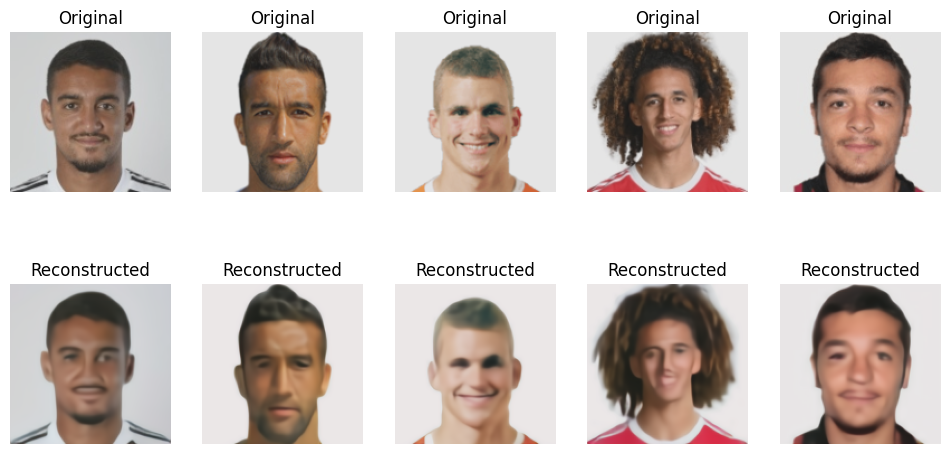

100%|██████████| 921/921 [02:41<00:00,  5.70it/s]


Epoch [8/10], Loss: 0.0008


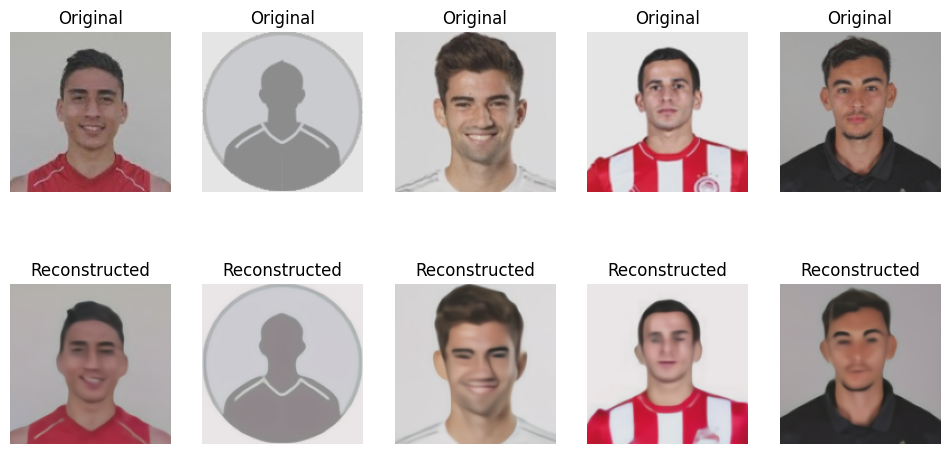

100%|██████████| 921/921 [02:41<00:00,  5.69it/s]


Epoch [9/10], Loss: 0.0007


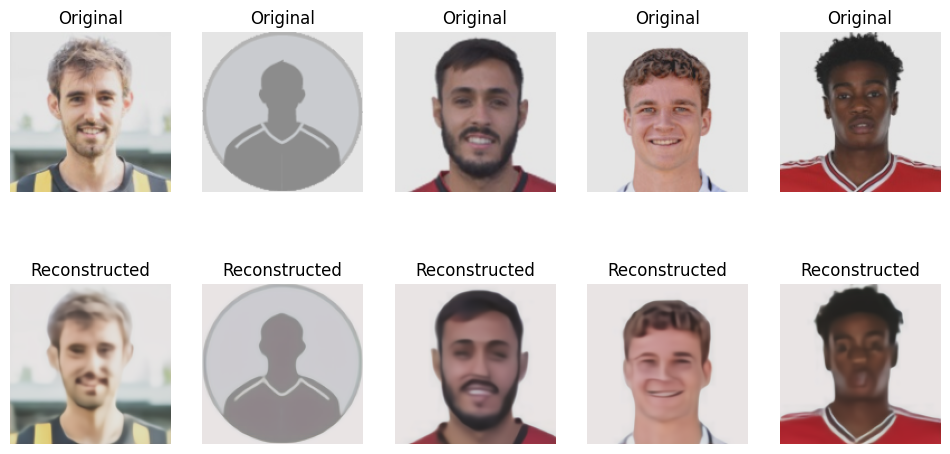

100%|██████████| 921/921 [02:41<00:00,  5.70it/s]


Epoch [10/10], Loss: 0.0007


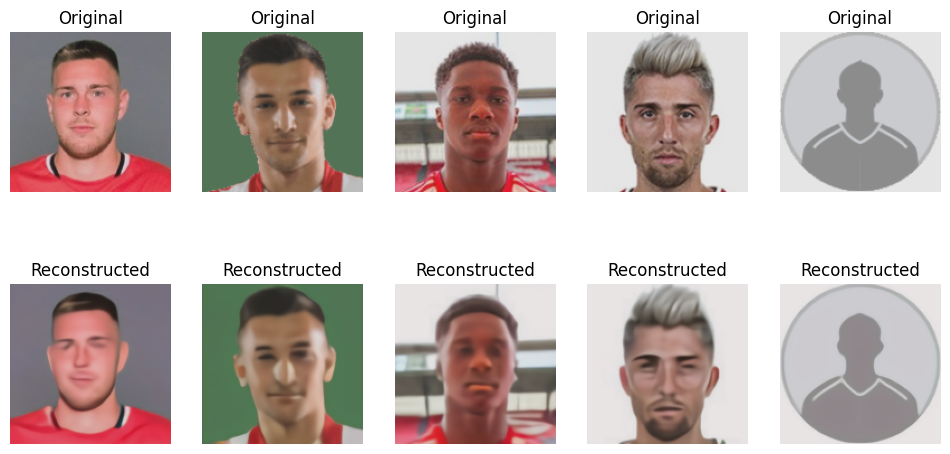

In [6]:
for name, param in dec.named_parameters():
    if "blocks.output" in name: 
        param.requires_grad = True
    else:
        param.requires_grad = False  


fine_tune_model(enc, dec, dataloader, epochs=10, lr=1e-5)


In [7]:
ENCODER_PATH = "checkpoints/vqvae_encoder.pth"
DECODER_PATH = "checkpoints/vqvae_decoder.pth"

torch.save(enc.state_dict(), ENCODER_PATH)  # Save encoder's weights
torch.save(dec.state_dict(), DECODER_PATH)  # Save decoder's weights
print("Models saved successfully!")


Models saved successfully!


In [8]:
torch.save(enc, "checkpoints/vqvae_encoder_full.pth")
torch.save(dec, "checkpoints/vqvae_decoder_full.pth")
print("Full models saved successfully!")

Full models saved successfully!


# Blending Try Part

In [8]:
import torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [9]:
enc = torch.load("checkpoints/vqvae_encoder_full.pth")
dec = torch.load("checkpoints/vqvae_decoder_full.pth")
enc.to(device)
dec.to(device)


Decoder(
  (blocks): Sequential(
    (input): Conv2d(n_in=8192, n_out=128, kw=1, use_float16=False, device=device(type='cpu'), requires_grad=False)
    (group_1): Sequential(
      (block_1): DecoderBlock(
        (id_path): Conv2d(n_in=128, n_out=2048, kw=1, use_float16=True, device=device(type='cpu'), requires_grad=False)
        (res_path): Sequential(
          (relu_1): ReLU()
          (conv_1): Conv2d(n_in=128, n_out=512, kw=1, use_float16=True, device=device(type='cpu'), requires_grad=False)
          (relu_2): ReLU()
          (conv_2): Conv2d(n_in=512, n_out=512, kw=3, use_float16=True, device=device(type='cpu'), requires_grad=False)
          (relu_3): ReLU()
          (conv_3): Conv2d(n_in=512, n_out=512, kw=3, use_float16=True, device=device(type='cpu'), requires_grad=False)
          (relu_4): ReLU()
          (conv_4): Conv2d(n_in=512, n_out=2048, kw=3, use_float16=True, device=device(type='cpu'), requires_grad=False)
        )
      )
      (block_2): DecoderBlock(
    

In [10]:
from PIL import Image

for images, _ in tqdm(dataloader):
    images = images.to(device)
    images = map_pixels(images)  
    
    with torch.no_grad():  
        z_logits = enc(images)
        z_indices = torch.argmax(z_logits, dim=1) 
        z_one_hot = nn.functional.one_hot(z_indices, num_classes=enc.vocab_size).permute(0, 3, 1, 2).float()
    
    x_stats = dec(z_one_hot).float()
    reconstructed_images = (torch.tanh(x_stats[:, :3]) + 1) / 2  

    reconstructed_images = reconstructed_images.clamp(0, 1)


In [4]:
uploaded_image_path = "./data/images/1155.png" 
img = Image.open(uploaded_image_path).convert("RGB")  

In [ ]:
z_logits = enc(img)
z_indices = torch.argmax(z_logits, dim=1)  # Latent codes
z_one_hot = nn.functional.one_hot(z_indices, num_classes=enc.vocab_size).permute(0, 3, 1, 2).float()
            

In [ ]:
x_stats = dec(z_one_hot).float()
reconstructed_images = (torch.tanh(x_stats[:, :3]) + 1) / 2  

reconstructed_images = reconstructed_images.clamp(0, 1)